<a id="top"></a>
# Look For Transients In FFI's In Nearby Galaxies
***

## Prerequisites
- Basic Python syntax, such as WHAT
- Familiarity with types of [extragalactic transients](https://astrobites.org/2022/10/30/guide-to-transient-astronomy/)

## Learning Goals

Original description: "Use FFI cutout tool to extract areas centered on nearby galaxies to search for extragalactic transients north of -30 degrees. The declination limit is chosen so that higher resolution PanSTARRS data are also available for post-detection analysis."

By the end of this tutorial, you will:

- Maybe something about narrowing down the list of possible targets? Do we want these nearby so they are resolved?
- Use the TESScut feature of astroquery to find a full-frame image time series of a nearby galaxy.
- Use something, lightkurve maybe? to determine if a transient event occured in the galaxy
- Maybe also check if PanSTARRS data is also available - but what to do with it?

## Introduction

Basic draft:
- TESS for searching for exoplanets, but galaxies also contained in the images, can be examined over times.
- Define FFI's
- Since 2018, TESS has been observing all parts of the sky, with particular overlapping coverage near the ecliptic poles. We will focus on data visible from the Northern hemisphere, so that there may be Pan-STARRS data for further analysis. SO WHICH YEARS NORTHERN DATA
- Transients (link) such as SN so bright (numbers), notable in the time series brightness of the galaxy (are we doing galaxy-integrated counts?)
- 

IS THIS OKAY OR DO WE WANT A SEPARATE TOC SECTION?

The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

HAVEN'T EDITED YET
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations

# Added by JRK
from astroquery.mast import Tesscut
from astropy.visualization import time_support
import lightkurve as lk
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord

***

# Headers Here

## Get dates and coordinates of TESS FFIs from MAST

The [TESS Observations](https://tess.mit.edu/observations/) page provides useful tables, including the start/end times of each sector's observing period and the coordinates of each camera during the sector. We can use that information to figure out if a known transient phenomenon was observed by TESS. We can cleverly use a query to the MAST archive to find this information. Let's use the [astropy.mast Observations.query_criteria](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries) function to view a table of all of the TESS Full Frame Images (FFI's). The key is to know that these are found using `target_name='TESS FFI'`. After returning the results table, we'll see how long it is, sort it by `t_min` (the observation start time; see below), and view the first three rows.

In [2]:
FFIs = Observations.query_criteria(project='TESS',target_name='TESS FFI')
print('Length of FFI table: ',len(FFIs))
FFIs.sort('t_min')
FFIs[0:3]

Length of FFI table:  1024


intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str138,str1,str1,str6,bool,float64,str9,str9
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-4,90.1643281891118,-57.92584112870806,image,"Ricker, George",3,58324.81152043981,58352.665975219905,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 105.899667 -56.995715 90.217793 -66.365128 74.608816 -56.588676 90.126494 -49.786515 105.899667 -56.995715,--,--,PUBLIC,False,nan,60865633,112737321
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-3,111.02618019992941,-65.25129027308752,image,"Ricker, George",3,58324.811805763886,58352.66567248842,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 127.603843 -61.771365 121.073669 -72.986467 90.505928 -66.484247 106.156464 -57.080944 127.603843 -61.771365,--,--,PUBLIC,False,nan,60865632,112737249
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-1,69.43886632081164,-64.91659705929159,image,"Ricker, George",3,58324.81275704861,58352.66720539352,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 53.472874 -61.115537 74.173119 -56.729652 89.699294 -66.564985 59.740565 -72.687978 53.472874 -61.115537,--,--,PUBLIC,False,nan,60865630,112737000


The MAST documentation includes more information about these [table columns](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). Some of the most important columns for our purposes will be:
- `obds_id` which we can parse into the sector name, camera number, and the CCD number. As we can see from the [TESS Observations](https://tess.mit.edu/observations/) page, the total field of view is a 24$^\circ$ by 96$^\circ$ rectangle, divided into 4 cameras, each of which is divided into 4 CCD's.  For example, an `obs_id` of `tess-s0020-1-3` indicates the observation associated with TESS Sector 10, Camera 1, CCD 3. 
- `s_ra` and `s_dec`, the coordinates of the center of the image
- `t_min` and `t_max`, the start and end time of the observations in MJD or "Modified Julian Date" which is the Julian Date minus 2400000.5
- `s_region`, a list of the corners of the field of view of this observation. The field of view for each CCD is about a 12$^\circ$ by 12$^\circ$ square. 

Let's examine the first value of the `s_region` column, which we can see is a long string with the values separated by spaces.

In [3]:
FFIs['s_region'][0]

'POLYGON 105.899667 -56.995715 90.217793 -66.365128 74.608816 -56.588676 90.126494 -49.786515 105.899667 -56.995715'

We can parse this information by splitting the string into pieces everywhere there is a space. In that case, the [1,3,5,7,9] elements represent RA's and the [2,4,6,8,10] elements represent declinations, all in decimal degrees. We'll also convert those from strings to floats for calculations. Let's view the shape traced out by these coordinates.

Text(0, 0.5, 'Dec (decimal degrees)')

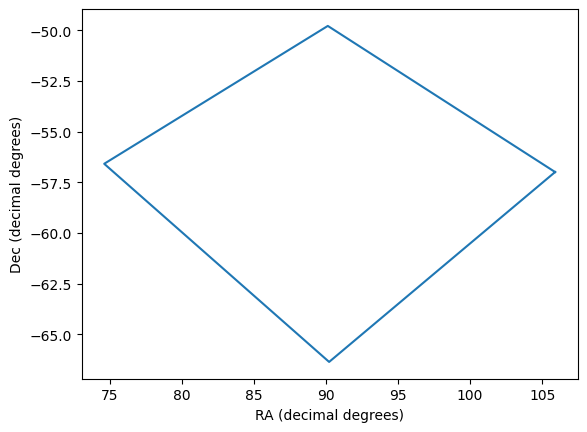

In [4]:
example_RAs=[float(FFIs['s_region'][0].split(' ')[i]) for i in [1,3,5,7,9]]
example_Decs=[float(FFIs['s_region'][0].split(' ')[i]) for i in [2,4,6,8,10]]
plt.plot(example_RAs,example_Decs)
plt.xlabel('RA (decimal degrees)')
plt.ylabel('Dec (decimal degrees)')

These coordinates do not look particularly square, because we are representing a portion of a sphere with a flat surface and we did not attempt to account for any projection effects. We know for sure that if our target is within 6 degrees of the center, it will be within the CCD's field of view (this defines the largest circle that can fit inside the square). A target at the corner of the field of view would be about $\sqrt{(6^\circ)^2+(6^\circ)^2} \approx 8.5^\circ$ away from the center; but not all targets between $6^\circ$ and $8.5$\circ are within the field of view. 

For the purposes of this tutorial, we'll just see if targets are within $6^\circ$ of the center of the CCD. To do a more complete search, which would include targets in the corners of the square (outside of the central circle), you could either use linear algebra concepts or install new Python packages such as [Regions](https://astropy-regions.readthedocs.io/en/stable/index.html). 

In [5]:
nFFI=len(FFIs)

## Using ZTF list already pre-sorted by those with TESS

https://ui.adsabs.harvard.edu/abs/2020AAS...23515709P/abstract

https://sites.astro.caltech.edu/ztf/bts 

In [7]:
#tab=Table.read('ZTF_brightSN_TESS.csv')
url='https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&classexclude=&ztflink=lasair&lastdet=&startsavedate=&startpeakdate=&startra=&startdec=&startz=&startdur=&startrise=&startfade=&startpeakmag=&startabsmag=&starthostabs=&starthostcol=&startb=&startav=&endsavedate=&endpeakdate=&endra=&enddec=&endz=&enddur=&endrise=&endfade=&endpeakmag=19.0&endabsmag=&endhostabs=&endhostcol=&endb=&endav=&reverse=y&format=csv'
tab=Table.read(url,format='csv')

In [8]:
tab

ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
str12,str10,str11,str11,float64,str1,float64,str6,str8,str7,str8,str10,str7,float64,float64
ZTF23aapbrrq,SN2023ljf,14:25:55.53,+34:31:22.9,2118.75,g,18.1726,-15.92,>1.98,>1.93,>0.05,SN Ib,0.015,68.47276671,0.037
ZTF23aaoygit,SN2023ker,16:22:10.69,+26:36:53.5,2118.81,r,18.7533,-18.50,>2.02,>2.02,>0,SN Ia,0.06378,52.52292002,0.037
ZTF23aaotalq,SN2023lgy,09:59:03.40,+33:28:38.9,2116.72,r,18.4381,-18.24,>2,>2,>0,SN Ia,0.04920,52.52292002,0.037
ZTF23aaochbp,SN2023kos,11:27:35.79,+18:01:53.5,2117.77,g,18.1813,-19.62,>6.02,>6.02,>0,SN Ia,0.08,68.65776663,0.065
ZTF23aaocgse,SN2023kvi,11:00:05.48,+23:56:35.8,2115.74,g,18.5228,-18.61,>3.99,>3.99,>0,SN Ia,0.06,64.73335704,0.041
ZTF23aaoanrl,AT2023ktd,21:05:37.11,+08:30:19.1,2115.91,g,18.6198,-19.19,>4.568,4.558,>0.01,SN Ia,0.072,-24.7683687,0.273
ZTF23aanzmoz,SN2023kyi,19:16:43.95,-17:30:34.8,2115.93,g,18.9847,-16.97,>5.07,>5.07,>0,SN II,0.02987,-13.3367575,0.331
ZTF23aanzbtf,AT2023ksy,18:06:49.80,+27:29:15.8,2115.81,r,18.9262,-18.96,>5.07,>4.98,>0.09,SN Ia,0.078,21.29480992,0.27
ZTF23aanxepa,SN2023ktu,15:45:35.39,+05:12:56.9,2119.79,g,18.0761,-19.43,>7.707,7.707,>0,SN Ia,0.067,43.15309181,0.15


More information about the columns can be found in the [ZTF Bright Transient Survey Sample Explorer documentation](https://sites.astro.caltech.edu/ztf/bts/explorer_info.html). The columns we are most interested in are:
- `RA` and `Dec`, which we'll use to see if these targets are in any TESS sectors.
- `time`, the time of the peak brightness, expressed as JD-2458000.

## Trying to search for observations with the right timing

In [9]:
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESS')

In [10]:
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESStimed')

We'd like to know if any of the period from half-peak to peak and back to half-peak again. Because the TESS segments are about 27 days, we'll be interested in observations with start time is up to 26 days before the first half-peak or up to the second half-peak. 

In [31]:
# Create SkyCoordinate objects for each row in the FFI table
FFIs['SkyCoord']=SkyCoord(FFIs['s_ra'],FFIs['s_dec'],unit=(u.deg,u.deg))

In [34]:
# Create SkyCoordinate objects for each row in the target table.
tab['SkyCoord']=SkyCoord(tab['RA'],tab['Dec'],unit=(u.hourangle,u.deg))

In [38]:
# Create peak Time objects for reach row in the target table.
tab['peakTime']=Time(tab['peakt']+2458000,format='jd')

In [89]:
# Create columsn for the min and max mjd, as floats.
tab['minStart']=tab['peakTime'].mjd-float(row['rise'].strip('>')[-1])-27
tab['maxStart']=tab['peakTime'].mjd+float(row['fade'].strip('>')[-1])

In [52]:
%%time
tab['nTESS']=[np.sum(c.separation(FFIs['SkyCoord'])<6*u.deg) for c in tab['SkyCoord']]

CPU times: user 14.9 s, sys: 11.8 ms, total: 14.9 s
Wall time: 14.9 s


In [ ]:
%%time
for i,row in enumerate(tab):
    arr1=(row['SkyCoord'].separation(FFIs['SkyCoord'])<6*u.deg)
    arr2=np.array([row['minStart'] <= start <= row['maxStart'] for start in FFIs['t_min']])
    tab['nTESS'][i]=np.sum(arr1)
    tab['nTESStimed'][i]=np.sum((arr1) & (arr2))
    if np.mod(i,500)==0: 
        print(i,'/',len(tab))

In [91]:
print(np.sum(tab['nTESS']>0))
print(np.sum(tab['nTESStimed']>0))

7039
550


In [2]:
#tab.write('ZTF_tested.csv')
tab=Table.read('ZTF_tested.csv')

In [3]:
tab=tab[tab['nTESStimed']>0]
tab.sort('peakmag')
print(tab['IAUID','peakmag','nTESStimed','nTESS','minStart','maxStart'])

  IAUID    peakmag nTESStimed nTESS      minStart           maxStart     
---------- ------- ---------- ----- ------------------ ------------------
 SN2023bee  13.084          1     3  59961.31999999983  59997.31999999983
 SN2021fxy 13.9347          1     3  59274.29000000004  59310.29000000004
 SN2022frl 14.9641          1     1 59660.310000000056 59696.310000000056
SN2022aaad 15.2139          1     6 59918.279999999795 59954.279999999795
 SN2019pxd  15.667          1     1 58717.169999999925 58753.169999999925
         - 15.7306          1     2  59833.35999999987  59869.35999999987
 SN2019pig 15.7411          1     3  58704.12999999989  58740.12999999989
 SN2021zny  15.783          1     2  59463.35999999987  59499.35999999987
 SN2022xzm  15.853          1     1 59852.169999999925 59888.169999999925
 SN2022yqv 15.8589          1     8  59863.14999999991  59899.14999999991
       ...     ...        ...   ...                ...                ...
 SN2022eaz 18.9664          1     3  5

In [5]:
i=0
row=tab[i]
obs_table=Observations.query_criteria(objectname=row['IAUID'],project='TESS',target_name='TESS FFI',
                               t_min=[row['minStart'],row['maxStart']])
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str115,str1,str1,str6,bool,float64,str9,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0061-1-2,132.85635447219107,-8.698760820108628,image,"Ricker, George",3,59962.29787282407,59987.728740300925,158.399927,600.0,1000.0,--,59999.0,N/A,--,61,POLYGON 125.419531 -13.055741 128.389622 -1.517737 140.275604 -4.454168 137.333774 -15.570268 125.419531 -13.055741,--,--,PUBLIC,False,nan,118308869,217885475,217885475,0.0


In [10]:
sectors=[int(x.split('-')[1].split('s')[1]) for x in obs_table['obs_id']]
sectors

[61]

## Looking at the observations from one galaxy at a time

In [12]:
search_result=lk.search_tesscut(row['IAUID'],sector=sectors)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 61,2023,TESScut,158,SN2023bee,0.0


In [17]:
# Size, make sure it's odd, to have a central pixel.
size=10

In [18]:
# Make a note of where they go - mastDownload/HLSP
tpf = search_result.download_all(cutout_size=size)

In [14]:
np.shape(tpf[0].flux)

(10653, 10, 10)

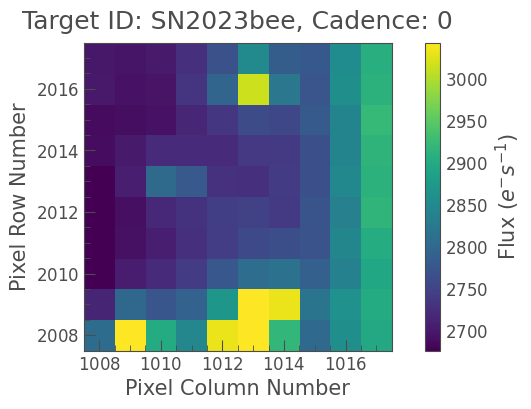

In [15]:
for i in range(len(tpf)): tpf[i].plot()#aperture_mask=target_mask, mask_color='k')

Because these galaxies are not TESS targets (bright stars around which we are looking for exoplanets), there is no pre-defined pipeline aperture mask. There are procedures to use thresholding to create an aperture mask: [How to cut out Target Pixel Files from Kepler Superstamps or TESS FFIs?](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-cutting-out-tpfs.html)

JRK Something about in our case we'll want to use the central pixel....

In [21]:
array_size = size
central_index = array_size // 2
target_mask = np.full((array_size, array_size), False, dtype=bool)
# Set the central element to True
target_mask[central_index, central_index] = True

In [22]:
target_lc=tpf[0].to_lightcurve(aperture_mask=target_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

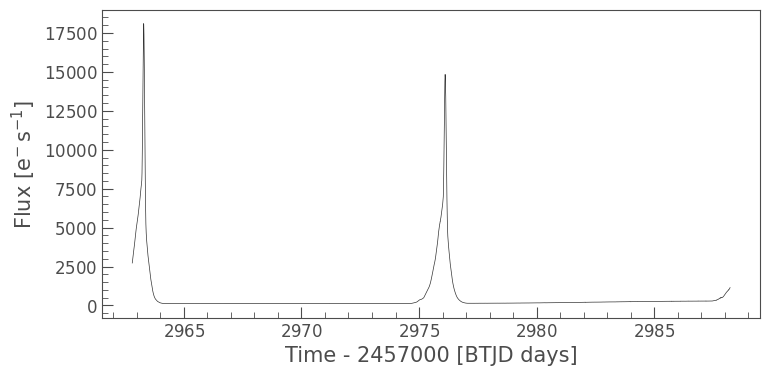

In [23]:
target_lc.plot()

In [24]:
background_mask = ~tpf[0].create_threshold_mask(threshold=0.001, reference_pixel=None)
n_background_pixels = background_mask.sum()
n_background_pixels

50

<AxesSubplot:title={'center':'Target ID: SN2023bee, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

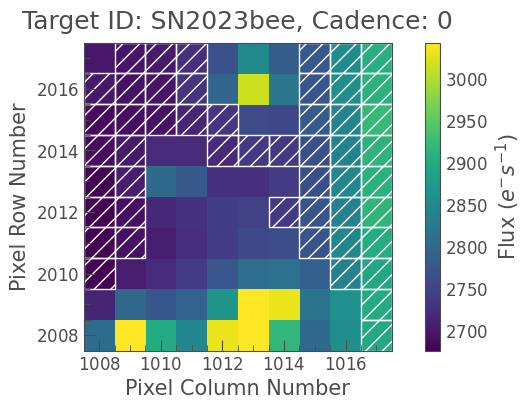

In [25]:
tpf[0].plot(aperture_mask=background_mask,mask_color='w')

In [26]:
background_lc_per_pixel = tpf[0].to_lightcurve(aperture_mask=background_mask) / n_background_pixels

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

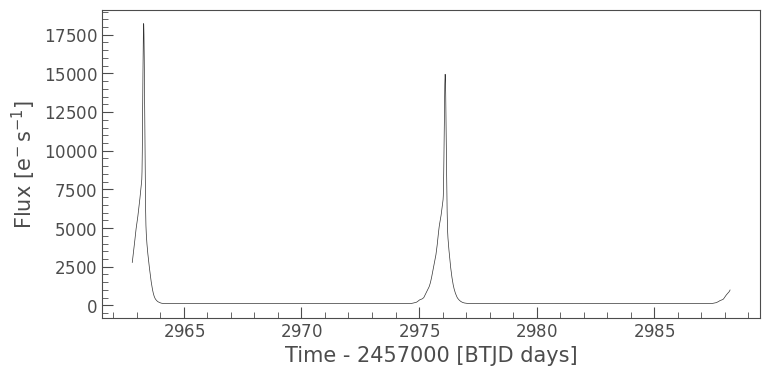

In [28]:
background_lc_per_pixel.plot()

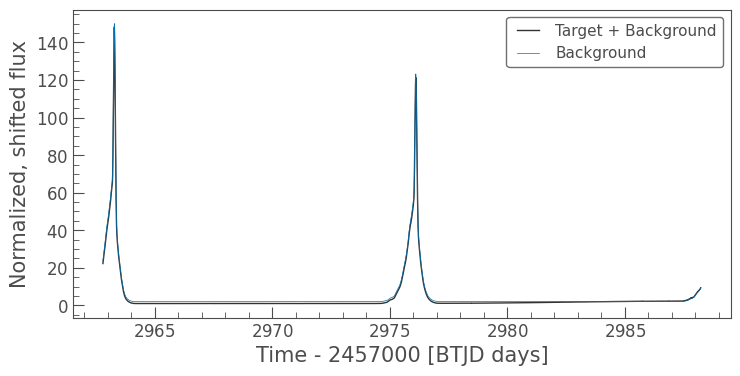

In [29]:
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_lc_per_pixel / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');

In [31]:
corrected_lc = target_lc - background_lc_per_pixel.flux

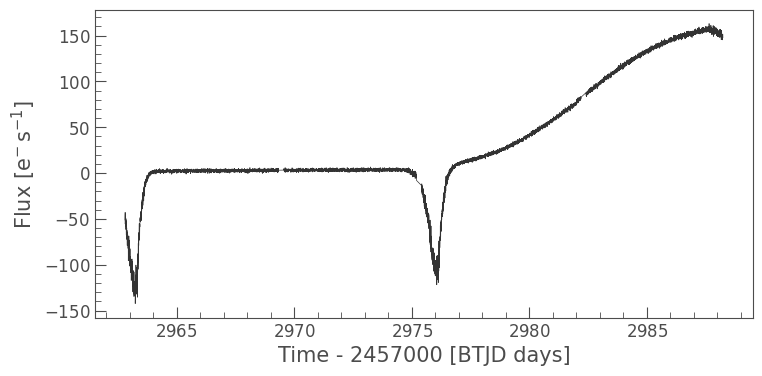

In [33]:
corrected_lc.plot();

In [ ]:
# Keep this if we do one with more than one...? Or an exercise, choose one with more than one.
#Basically, we need to get all the TPFs, 
# make an aperture mask for each one, a background mask for each one, a bg-subtracted lightcurve for each one, 
# and then put those lightcurves together as a lightcurve collection
n_sectors=len(tpf)
print(n_sectors)
for j in np.arange(n_sectors):
    #target_mask=tpf[j].create_threshold_mask(threshold=3, reference_pixel='center')
    n_target_pixels
    # What if the target mask were just the central pixel - if we made this cutout based on the coordinates of the SN...
    background_mask = ~tpf[j].create_threshold_mask(threshold=0.001, reference_pixel=None)
    
    n_target_pixels = target_mask.sum()
    print(n_target_pixels)
    
    n_background_pixels = background_mask.sum()
    print(n_background_pixels)
    
    target_lc=tpf[j].to_lightcurve(aperture_mask=target_mask)
    
    background_lc_per_pixel = tpf[j].to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    
    corrected_lc = target_lc - background_estimate_lc.flux
    
    tpf[j].plot(aperture_mask=target_mask,mask_color='k')
    tpf[j].plot(aperture_mask=background_mask,mask_color='w')
    corrected_lc.plot()
    
    if j==0:
        lc=lk.LightCurveCollection([corrected_lc])
    else:
        lc.append(corrected_lc)

In [ ]:
#lc=lk.LightCurveCollection([lc1,lc2])
lc.plot()
#plt.axvline(t.jd-2457000,linestyle='solid')
#plt.axvline(thalf1.jd-2457000,linestyle='dashed') 
#plt.axvline(thalf2.jd-2457000,linestyle='dashed') 

### Choosing a target galaxy

Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

If the user needs to download data to run the tutorial properly, where possible, use [astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)

## About this Notebook
**Author(s):** Julia Kamenetzky, ScienceBetter Consultatnt <br>
**Keyword(s):** Tutorial, TIKEBook, TESSCut, FFI, transients, galaxies <br>
**Last Updated:** May 2023 <br>
**Next Review:** Dec 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 